In [170]:
#[(phase, Vector of string with the Gate name and qubit indices)]
#implement a function that takes in a list of Pauli strings and builds a ZX graph with W inputs and outputs using method from https://arxiv.org/pdf/2212.04462

In [171]:
import pyzx as zx
import sympy as sp
import random
import numpy as np

In [172]:
def generate_random_pauli_string(strings, qubits):
    """
    Generate a random Pauli string Hamiltonian.
    
    Args:
        strings: Number of Pauli terms to generate
        qubits: Total number of qubits available
    
    Returns:
        List of tuples: [(coefficient, [gate_list]), ...]
        Example: [(0.5, ["X0", "X1"]), (-0.3, ["Y2", "Z3"])]
        
    The coefficients represent coupling strengths in the Hamiltonian:
    H = Σ coefficient_i * (Pauli_string_i)
    """
    pauli_string = []
    pauli_ops = ['X', 'Y', 'Z']
    
    for _ in range(strings):
        # Generate random coupling coefficient
        # For realistic Hamiltonians (like from PySCF):
        # - Use Gaussian distribution centered at 0 (most terms are small)
        # - Standard deviation ~0.5 gives reasonable energy scales
        # - This mimics electronic structure coefficients
        
        coefficient = np.random.normal(0, 0.5)  # Mean=0, StdDev=0.5
        
        # Alternative distributions:
        # coefficient = np.random.uniform(-1, 1)  # Uniform in [-1, 1]
        # coefficient = np.random.randn()  # Standard normal (mean=0, std=1)
        # coefficient = np.random.exponential(0.3) * np.random.choice([-1, 1])  # Exponential with random sign
        
        # Random number of gates in this term (1 to min(4, qubits))
        num_gates = random.randint(1, min(4, qubits))
        
        # Randomly select qubits (without replacement for this term)
        selected_qubits = random.sample(range(qubits), num_gates)
        
        # Generate gates for each selected qubit
        gates = []
        for qubit_idx in selected_qubits:
            pauli_op = random.choice(pauli_ops)
            gates.append(f"{pauli_op}{qubit_idx}")
        
        pauli_string.append((coefficient, gates))
    return pauli_string

In [173]:
# Reduce problem size to avoid memory issues
# For large systems, use fewer qubits and fewer Pauli strings
pauli_string = generate_random_pauli_string(10, 10)  # 5 strings, 4 qubits max

# Alternative: use the original small example
# pauli_string = [(3.0,["X0","X1"]),(1.0,["X1","X2"]),(-1.0,["Z0"]),(-1.0,["Z1"]),(-1.0,["Z2"]), (1.0,["Y0","X3","Z4" ,"Y5"])]

In [174]:
total_qubits = 0

for term in pauli_string:
    # Get the number from the gate names to determine the number of qubits
    qubit_indices = [int(gate[1:]) for gate in term[1]]
    max_index = max(qubit_indices)
    if max_index > total_qubits:
        total_qubits = max_index
    print("Alpha:", term[0], "Gates:", term[1])
    
total_qubits += 1  # Adjust for 0-based indexing
print("Total qubits needed:", total_qubits)

Alpha: 0.6813810454289386 Gates: ['Z7', 'Z9']
Alpha: -0.4621310685923721 Gates: ['Y7']
Alpha: 0.13752056488171452 Gates: ['X3']
Alpha: -0.6785539123337568 Gates: ['Y7', 'X0', 'Y5', 'Z9']
Alpha: 0.600906947960077 Gates: ['Y2', 'Z6', 'X4', 'Z8']
Alpha: -0.28297998130355895 Gates: ['Y5']
Alpha: 0.5656632924674275 Gates: ['Z6', 'Y0']
Alpha: 1.0372991529498705 Gates: ['X6', 'Z7', 'Y9']
Alpha: 0.3179952115509475 Gates: ['Y4', 'Z7']
Alpha: 0.23079219258343445 Gates: ['Y7', 'Z6', 'Z1', 'Z9']
Total qubits needed: 10


In [175]:
main_graph = zx.Graph()
inps = []
for q in range(total_qubits):
    in_vertex = main_graph.add_vertex(zx.VertexType.BOUNDARY, qubit=q, row=0)
    inps.append(in_vertex)
main_graph.set_inputs(inps)
# zx.draw(main_graph, labels=True)

In [176]:
import fractions
from fractions import Fraction
current_row = 1  # Start adding operations from row 1
z_vertices_to_connect = []
for term in pauli_string:
    phase = term[0]
    gates = term[1]
    curr_list = []
    for gate in gates:
        gate_type = gate[0]
        qubit_index = int(gate[1:])
        
        row_increment = 0
        
        if gate_type == 'X':
            first_hadamard = main_graph.add_vertex(zx.VertexType.H_BOX, qubit=qubit_index, row=current_row)
            z_vertex = main_graph.add_vertex(zx.VertexType.Z, qubit=qubit_index, row=current_row + 1)
            second_hadamard = main_graph.add_vertex(zx.VertexType.H_BOX, qubit=qubit_index, row=current_row + 2)

            main_graph.add_edge((first_hadamard, z_vertex))
            main_graph.add_edge((z_vertex, second_hadamard))
            
            row_increment += 3
            
            curr_list.append(z_vertex)
        elif gate_type == 'Z':
            z_vertex = main_graph.add_vertex(zx.VertexType.Z, qubit=qubit_index, row=current_row)
            row_increment += 1
            
            curr_list.append(z_vertex)
        elif gate_type == 'Y':
            x_vertex_one = main_graph.add_vertex(zx.VertexType.X, qubit=qubit_index, row=current_row, phase=Fraction(1,2))
            z_vertex = main_graph.add_vertex(zx.VertexType.Z, qubit=qubit_index, row=current_row + 1)
            x_vertex_two = main_graph.add_vertex(zx.VertexType.X, qubit=qubit_index, row=current_row + 2, phase=Fraction(-1,2))
            
            main_graph.add_edge((x_vertex_one, z_vertex))
            main_graph.add_edge((z_vertex, x_vertex_two))
            
            row_increment += 3
            
            curr_list.append(z_vertex)
            
        print("Adding gate:", gate_type, "on qubit", qubit_index)
        
    z_vertices_to_connect.append(curr_list)
        
    current_row += row_increment
print(z_vertices_to_connect)
z_vertices_to_connect_cpy = z_vertices_to_connect.copy()

Adding gate: Z on qubit 7
Adding gate: Z on qubit 9
Adding gate: Y on qubit 7
Adding gate: X on qubit 3
Adding gate: Y on qubit 7
Adding gate: X on qubit 0
Adding gate: Y on qubit 5
Adding gate: Z on qubit 9
Adding gate: Y on qubit 2
Adding gate: Z on qubit 6
Adding gate: X on qubit 4
Adding gate: Z on qubit 8
Adding gate: Y on qubit 5
Adding gate: Z on qubit 6
Adding gate: Y on qubit 0
Adding gate: X on qubit 6
Adding gate: Z on qubit 7
Adding gate: Y on qubit 9
Adding gate: Y on qubit 4
Adding gate: Z on qubit 7
Adding gate: Y on qubit 7
Adding gate: Z on qubit 6
Adding gate: Z on qubit 1
Adding gate: Z on qubit 9
[[10, 11], [13], [16], [19, 22, 25, 27], [29, 31, 33, 35], [37], [39, 41], [44, 46, 48], [51, 53], [55, 57, 58, 59]]


In [177]:
outs = []
for q in range(total_qubits):
    out_vertex = main_graph.add_vertex(zx.VertexType.BOUNDARY, qubit=q, row=current_row)
    outs.append(out_vertex)
main_graph.set_outputs(outs)

In [178]:
for q in range(total_qubits):
    #find all vertices for qubit q
    vertices_on_qubit = [v for v in main_graph.vertices() if main_graph.qubit(v) == q]
    edges = main_graph.edge_set()
    
    # run through vertices and check wich are not connected
    for i in range(len(vertices_on_qubit)):
        v1 = vertices_on_qubit[i]
        
        if i+1 >= len(vertices_on_qubit):
            break
        
        v2 = vertices_on_qubit[i+1]
        if (v1, v2) not in edges and (v2, v1) not in edges:
            main_graph.add_edge((v1, v2))

In [179]:
zx.draw(main_graph, labels=True)
main_graph_cpy = main_graph.copy()

In [180]:
top_graph = zx.Graph()
root_x_vertex = top_graph.add_vertex(zx.VertexType.X, qubit=0, row=0, phase=1)
w_input = top_graph.add_vertex(zx.VertexType.W_INPUT, qubit=0, row=1)
w_output = top_graph.add_vertex(zx.VertexType.W_OUTPUT, qubit=0, row=2)
top_graph.add_edge((root_x_vertex, w_input))
top_graph.add_edge((w_input, w_output)) 

w_labels = {w_input: "W_IN", w_output: "W_OUT"}

x_vertex_to_connect = []

for i, elm in enumerate(pauli_string):
    z_box = top_graph.add_vertex(zx.VertexType.Z_BOX, qubit=3, row=i+1)
    x = top_graph.add_vertex(zx.VertexType.X, qubit=4, row=i+1)
    zx.utils.set_z_box_label(top_graph, z_box, elm[0])
    
    top_graph.add_edge((w_output, z_box))
    top_graph.add_edge((z_box, x), edgetype=zx.EdgeType.HADAMARD)
    
    x_vertex_to_connect.append(x)

In [181]:
zx.draw(top_graph, labels=w_labels)

In [182]:
top_graph_verts = len(top_graph.vertices())
print("Top graph vertices:", top_graph_verts)
# Shift z_vertices_to_connect indices to account for vertices in top_graph when tensoring
z_vertices_to_connect = [[v + top_graph_verts for v in lst] for lst in z_vertices_to_connect]
print("Shifted z_vertices_to_connect:", z_vertices_to_connect)
print("X vertices to connect:", x_vertex_to_connect)
tot_graph = top_graph.tensor(main_graph)

for i in range(len(x_vertex_to_connect)):
    for j in range(len(z_vertices_to_connect[i])):
        tot_graph.add_edge((x_vertex_to_connect[i], z_vertices_to_connect[i][j]))
zx.draw(tot_graph, labels=True)

Top graph vertices: 23
Shifted z_vertices_to_connect: [[33, 34], [36], [39], [42, 45, 48, 50], [52, 54, 56, 58], [60], [62, 64], [67, 69, 71], [74, 76], [78, 80, 81, 82]]
X vertices to connect: [4, 6, 8, 10, 12, 14, 16, 18, 20, 22]


In [183]:
zx.hsimplify.from_hypergraph_form(tot_graph)

zx.simplify.full_reduce(tot_graph)
zx.draw(tot_graph, labels=True)

In [184]:
time_step = 0.1
trotter_steps = 3
trotter_top = zx.Graph()
trotter_to_connect = []
for i, elm in enumerate(pauli_string):
    term = elm[0] * time_step / trotter_steps
    print("Trotter term:", term)
    # Build Trotter step graph here
    v1 = trotter_top.add_vertex(zx.VertexType.Z, qubit=0, row=i, phase=term)
    v2 = trotter_top.add_vertex(zx.VertexType.X, qubit=1, row=i)
    trotter_top.add_edge((v1, v2), edgetype=zx.EdgeType.HADAMARD)
    trotter_to_connect.append(v2)

zx.draw(trotter_top, labels=True)
zx.draw(main_graph_cpy, labels=True)
print(z_vertices_to_connect_cpy)

Trotter term: 0.022712701514297953
Trotter term: -0.01540436895307907
Trotter term: 0.004584018829390485
Trotter term: -0.02261846374445856
Trotter term: 0.020030231598669235
Trotter term: -0.009432666043451965
Trotter term: 0.018855443082247587
Trotter term: 0.03457663843166235
Trotter term: 0.010599840385031584
Trotter term: 0.007693073086114482


[[10, 11], [13], [16], [19, 22, 25, 27], [29, 31, 33, 35], [37], [39, 41], [44, 46, 48], [51, 53], [55, 57, 58, 59]]


In [185]:
trotter_top_verts = len(trotter_top.vertices())
print("Top graph vertices:", trotter_top_verts)
# Shift z_vertices_to_connect indices to account for vertices in top_graph when tensoring
z_vertices_to_connect = [[v + trotter_top_verts for v in lst] for lst in z_vertices_to_connect_cpy]
print("Shifted z_vertices_to_connect:", z_vertices_to_connect)
print("X vertices to connect in trotter term:", trotter_to_connect)
tot_graph = trotter_top.tensor(main_graph_cpy)
zx.draw(tot_graph, labels=True)
for i in range(len(z_vertices_to_connect_cpy)):
    for j in range(len(z_vertices_to_connect_cpy[i])):
        tot_graph.add_edge((trotter_to_connect[i], z_vertices_to_connect[i][j]))
zx.draw(tot_graph, labels=True)

Top graph vertices: 20
Shifted z_vertices_to_connect: [[30, 31], [33], [36], [39, 42, 45, 47], [49, 51, 53, 55], [57], [59, 61], [64, 66, 68], [71, 73], [75, 77, 78, 79]]
X vertices to connect in trotter term: [1, 3, 5, 7, 9, 11, 13, 15, 17, 19]


Converting ZX diagram to Quimb tensor network...
Inputs: 10, Outputs: 10
Total system size: 2^10 = 1024 dimensional Hilbert space

Successfully created Quimb tensor network!
Type: <class 'quimb.tensor.tensor_core.TensorNetwork'>
Number of tensors: 122
Number of indices: 90
Tensor network structure:
TensorNetwork([
    Tensor(shape=(2,), inds=('0',), tags=oset(['V'])),
    Tensor(shape=(2,), inds=('2',), tags=oset(['V'])),
    Tensor(shape=(2,), inds=('4',), tags=oset(['V'])),
    Tensor(shape=(2,), inds=('6',), tags=oset(['V'])),
    Tensor(shape=(2,), inds=('8',), tags=oset(['V'])),
    Tensor(shape=(2,), inds=('10',), tags=oset(['V'])),
    Tensor(shape=(2,), inds=('12',), tags=oset(['V'])),
    Tensor(shape=(2,), inds=('14',), tags=oset(['V'])),
    Tensor(shape=(2,), inds=('16',), tags=oset(['V'])),
    Tensor(shape=(2,), inds=('18',), tags=oset(['V'])),
    Tensor(shape=(2,), inds=('32',), tags=oset(['V'])),
    Tensor(shape=(2,), inds=('34',), tags=oset(['V'])),
    Tensor(shape=

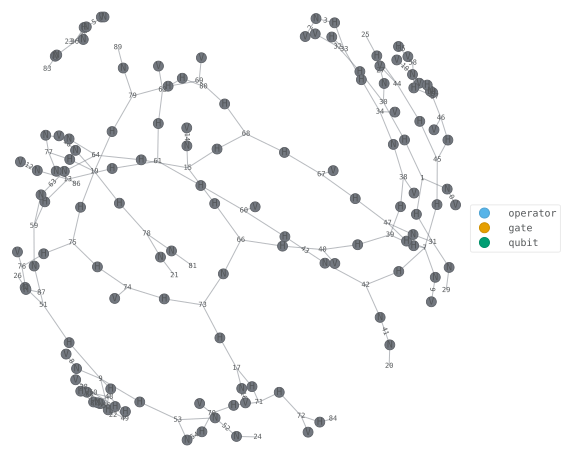

Tensor network visualization created!

TENSOR NETWORK DETAILS:

Tensor 1:
  Shape: (2,)
  Indices: ('0',)
  Tags: oset(['V'])
  Size in memory: 0.03 KB

Tensor 2:
  Shape: (2,)
  Indices: ('2',)
  Tags: oset(['V'])
  Size in memory: 0.03 KB

Tensor 3:
  Shape: (2,)
  Indices: ('4',)
  Tags: oset(['V'])
  Size in memory: 0.03 KB

Tensor 4:
  Shape: (2,)
  Indices: ('6',)
  Tags: oset(['V'])
  Size in memory: 0.03 KB

Tensor 5:
  Shape: (2,)
  Indices: ('8',)
  Tags: oset(['V'])
  Size in memory: 0.03 KB

Tensor 6:
  Shape: (2,)
  Indices: ('10',)
  Tags: oset(['V'])
  Size in memory: 0.03 KB

Tensor 7:
  Shape: (2,)
  Indices: ('12',)
  Tags: oset(['V'])
  Size in memory: 0.03 KB

Tensor 8:
  Shape: (2,)
  Indices: ('14',)
  Tags: oset(['V'])
  Size in memory: 0.03 KB

Tensor 9:
  Shape: (2,)
  Indices: ('16',)
  Tags: oset(['V'])
  Size in memory: 0.03 KB

Tensor 10:
  Shape: (2,)
  Indices: ('18',)
  Tags: oset(['V'])
  Size in memory: 0.03 KB

Tensor 11:
  Shape: (2,)
  Indices: ('32

F=6.27 C=7.95 S=20.00 P=20.32: 100%|██████████| 64/64 [00:01<00:00, 32.47it/s]


Contraction successful!
Result type: <class 'quimb.tensor.tensor_core.Tensor'>
Result data shape: (2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2)

Final matrix shape: (1024, 1024)
Matrix size in memory: 16.00 MB

COMPUTING EIGENVALUES

Number of eigenvalues: 1024

Top eigenvalues (sorted by magnitude):
  1: 0.007935+0.000026j (|λ| = 0.007935)
  2: -0.004098+0.006758j (|λ| = 0.007903)
  3: -0.003796-0.006928j (|λ| = 0.007899)
  4: 0.007889+0.000165j (|λ| = 0.007890)
  5: 0.007734+0.000183j (|λ| = 0.007736)
  6: 0.007722-0.000044j (|λ| = 0.007722)
  7: -0.003949+0.006586j (|λ| = 0.007679)
  8: -0.003723-0.006715j (|λ| = 0.007678)
  9: 0.000680-0.000142j (|λ| = 0.000695)
  10: -0.000664+0.000120j (|λ| = 0.000675)
  ... and 1014 more

Eigenvalue statistics:
  Max magnitude: 0.007935
  Min magnitude: 0.000000
  Mean magnitude: 0.000086
  Std deviation: 0.000694


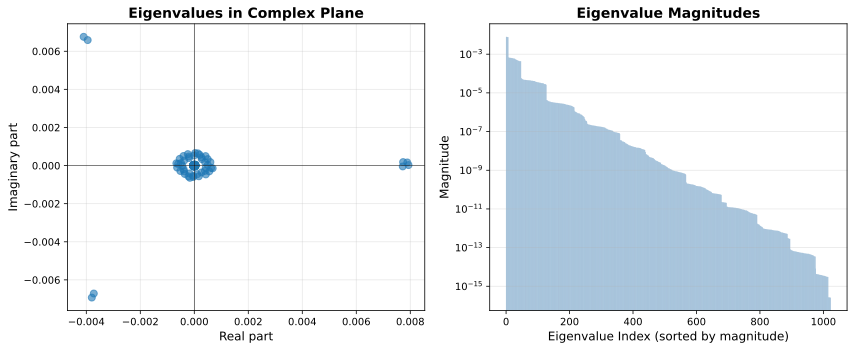

HAMILTONIAN ANALYSIS

Is matrix Hermitian? False
This could explain unexpected eigenvalue patterns.

Making matrix Hermitian: H_eff = (H + H†)/2

Hermitian eigenvalues (all real):
  1: 0.027762
  2: 0.027761
  3: 0.027704
  4: 0.027703
  5: 0.024387
  6: 0.024352
  7: 0.024309
  8: 0.024287
  9: 0.022306
  10: 0.022248

Hermitian eigenvalue statistics:
  Max: 0.027762
  Min: -0.026276
  Mean: 0.000015
  Std: 0.005530

Matrix properties:
  Norm (Frobenius): 0.250000
  Trace: 0.015607+0.000459j
  Determinant: -0.000000e+00+0.000000e+00j

Eigenvalue distribution:
  Real part range: [-0.004098, 0.007935]
  Imag part range: [-0.006928, 0.006758]
  Near-zero eigenvalues (|λ| < 1e-10): 390
  Unique eigenvalue magnitudes: 77 out of 1024


In [186]:
# Install cotengra if needed
# !pip install cotengra

import quimb.tensor as qtn
import cotengra as ctg
from pyzx.quimb import to_quimb_tensor

print("Converting ZX diagram to Quimb tensor network...")

# Get number of inputs and outputs first
n_inputs = tot_graph.num_inputs()
n_outputs = tot_graph.num_outputs()
print(f"Inputs: {n_inputs}, Outputs: {n_outputs}")
print(f"Total system size: 2^{n_inputs} = {2**n_inputs} dimensional Hilbert space")

# Convert ZX diagram directly to Quimb TensorNetwork
# This preserves the graph structure without materializing the full tensor
try:
    tensor_network = to_quimb_tensor(tot_graph)
    print(f"\nSuccessfully created Quimb tensor network!")
    print(f"Type: {type(tensor_network)}")
    
    if isinstance(tensor_network, qtn.TensorNetwork):
        print(f"Number of tensors: {tensor_network.num_tensors}")
        print(f"Number of indices: {tensor_network.num_indices}")
        print(f"Tensor network structure:\n{tensor_network}")
        use_full_tensor = True
    else:
        # It's a single tensor (small system)
        print(f"Result is a single tensor with shape: {tensor_network.shape}")
        # Wrap it in a TensorNetwork for consistency
        tensor_network = qtn.TensorNetwork([tensor_network])
        print(f"Wrapped in TensorNetwork with {tensor_network.num_tensors} tensor(s)")
        use_full_tensor = True
        
except MemoryError:
    print("Memory error - tensor too large. Using graph-based approach instead.")
    use_full_tensor = False
    print("Please reduce the number of qubits or Pauli strings.")
    print("Recommended: 3-4 qubits max, 5-10 Pauli strings")
# Visualize the tensor network structure
if use_full_tensor:
    print("Drawing tensor network structure...")
    
    # Draw the tensor network
    # This shows how the tensors are connected
    try:
        fig = tensor_network.draw(
            color=['operator', 'gate', 'qubit'],  # Color by tags
            show_tags=True,                        # Show tensor tags
            show_inds='all',                       # Show all indices
            figsize=(14, 8),
            iterations=200,                        # Layout iterations
            k=0.5,                                 # Spring constant for layout
        )
        print("Tensor network visualization created!")
    except Exception as e:
        print(f"Could not draw network: {e}")
        print("Trying simplified visualization...")
        try:
            fig = tensor_network.draw(figsize=(12, 8))
        except Exception as e2:
            print(f"Simplified draw also failed: {e2}")
    
    # Print detailed information about the network
    print(f"\n{'='*60}")
    print("TENSOR NETWORK DETAILS:")
    print(f"{'='*60}")
    
    for i, tensor in enumerate(tensor_network.tensors):
        print(f"\nTensor {i+1}:")
        print(f"  Shape: {tensor.shape}")
        print(f"  Indices: {tensor.inds}")
        print(f"  Tags: {tensor.tags}")
        print(f"  Size in memory: {tensor.data.nbytes / 1024:.2f} KB")
    
    print(f"\n{'='*60}")
    print(f"Total network memory: {sum(t.data.nbytes for t in tensor_network.tensors) / (1024**2):.2f} MB")
    print(f"{'='*60}")
# Set up cotengra optimizer for efficient tensor network contraction
if use_full_tensor:
    print("\nSetting up Cotengra optimizer...")
    
    # Create an optimizer instance
    # HyperOptimizer will try multiple methods automatically
    optimizer = ctg.HyperOptimizer(
        methods=['greedy', 'kahypar'],  # Use multiple optimization methods
        max_repeats=64,                 # Number of optimization attempts
        max_time=20,                    # Maximum time in seconds
        minimize='flops',               # Minimize floating point operations
        progbar=True                    # Show progress bar
    )
    
    print(f"Optimizer configured successfully!")
    print(f"Will use greedy and kahypar methods for optimization")
    print(f"Max repeats: 64, Max time: 20 seconds")
    
    # Analyze the contraction complexity before optimization
    print(f"\nTensor network contraction analysis:")
    print(f"  Number of tensors to contract: {tensor_network.num_tensors}")
    print(f"  Number of unique indices: {tensor_network.num_indices}")
    
    # Get all indices and their types
    outer_inds = tensor_network.outer_inds()
    inner_inds = [ind for ind in tensor_network.ind_map.keys() if ind not in outer_inds]
    
    print(f"  Outer indices (inputs/outputs): {len(outer_inds)}")
    print(f"  Inner indices (to contract): {len(inner_inds)}")
    
    if tensor_network.num_tensors > 1:
        print("\n  Outer indices:", sorted(list(outer_inds))[:20])
        if len(outer_inds) > 20:
            print("    ...")
        print("  Inner indices:", sorted(inner_inds)[:20])
        if len(inner_inds) > 20:
            print("    ...")

# Contract the tensor network and compute eigenvalues
if use_full_tensor:
    print("\n" + "="*60)
    print("CONTRACTING TENSOR NETWORK")
    print("="*60)
    
    # Contract all indices to get the final operator matrix
    # This uses the cotengra optimizer to find the best path
    print("\nFinding optimal contraction path with Cotengra...")
    
    try:
        # Get the outer indices (these should remain after contraction)
        output_indices = tensor_network.outer_inds()
        print(f"Output indices to preserve: {sorted(list(output_indices))}")
        
        # Contract the tensor network using cotengra optimization
        # For hyper-networks, we need to explicitly specify output_inds
        result = tensor_network.contract(all, optimize=optimizer, output_inds=output_indices)
        
        print(f"Contraction successful!")
        print(f"Result type: {type(result)}")
        
        # Extract the data from the result
        if hasattr(result, 'data'):
            result_data = result.data
        else:
            result_data = result
            
        print(f"Result data shape: {result_data.shape}")
        
        # The result should be the full operator matrix
        # Reshape to proper matrix form for eigenvalue computation
        total_qubits_tn = n_inputs
        matrix_size = 2 ** total_qubits_tn
        
        # Reshape to matrix form (input indices × output indices)
        final_matrix = result_data.reshape(matrix_size, matrix_size)
        
        print(f"\nFinal matrix shape: {final_matrix.shape}")
        print(f"Matrix size in memory: {final_matrix.nbytes / (1024**2):.2f} MB")
        
        # Compute eigenvalues
        print("\n" + "="*60)
        print("COMPUTING EIGENVALUES")
        print("="*60)
        
        eigenvalues = np.linalg.eigvals(final_matrix)
        
        print(f"\nNumber of eigenvalues: {len(eigenvalues)}")
        print(f"\nTop eigenvalues (sorted by magnitude):")
        sorted_eigs = eigenvalues[np.argsort(np.abs(eigenvalues))[::-1]]
        for i, eig in enumerate(sorted_eigs[:10]):
            print(f"  {i+1}: {eig:.6f} (|λ| = {np.abs(eig):.6f})")
        if len(eigenvalues) > 10:
            print(f"  ... and {len(eigenvalues) - 10} more")
        
        # Show statistics
        print(f"\nEigenvalue statistics:")
        print(f"  Max magnitude: {np.max(np.abs(eigenvalues)):.6f}")
        print(f"  Min magnitude: {np.min(np.abs(eigenvalues)):.6f}")
        print(f"  Mean magnitude: {np.mean(np.abs(eigenvalues)):.6f}")
        print(f"  Std deviation: {np.std(np.abs(eigenvalues)):.6f}")
        
    except Exception as e:
        print(f"Error during contraction or eigenvalue computation: {e}")
        import traceback
        traceback.print_exc()
        
else:
    print("Cannot compute eigenvalues - system too large or tensor network not created.")
    print("Please reduce problem size.")
    
# Optional: Visualize eigenvalues
if use_full_tensor:
    import matplotlib.pyplot as plt
    
    plt.figure(figsize=(12, 5))
    
    # Plot 1: Eigenvalues in complex plane
    plt.subplot(1, 2, 1)
    plt.scatter(eigenvalues.real, eigenvalues.imag, alpha=0.6, s=50)
    plt.xlabel('Real part', fontsize=12)
    plt.ylabel('Imaginary part', fontsize=12)
    plt.title('Eigenvalues in Complex Plane', fontsize=14, fontweight='bold')
    plt.grid(True, alpha=0.3)
    plt.axhline(y=0, color='k', linewidth=0.5)
    plt.axvline(x=0, color='k', linewidth=0.5)
    
    # Plot 2: Magnitude of eigenvalues
    plt.subplot(1, 2, 2)
    sorted_mags = np.sort(np.abs(eigenvalues))[::-1]
    plt.bar(range(len(sorted_mags)), sorted_mags, alpha=0.7, color='steelblue')
    plt.xlabel('Eigenvalue Index (sorted by magnitude)', fontsize=12)
    plt.ylabel('Magnitude', fontsize=12)
    plt.title('Eigenvalue Magnitudes', fontsize=14, fontweight='bold')
    plt.grid(True, alpha=0.3, axis='y')
    plt.yscale('log')  # Use log scale to see small eigenvalues
    
    plt.tight_layout()
    plt.show()
else:
    print("Skipping visualization - no eigenvalues computed.")
    
# Diagnostic: Analyze the Hamiltonian structure
if use_full_tensor:
    print("="*60)
    print("HAMILTONIAN ANALYSIS")
    print("="*60)
    
    # Check if the matrix is Hermitian (should be for a physical Hamiltonian)
    is_hermitian = np.allclose(final_matrix, final_matrix.conj().T)
    print(f"\nIs matrix Hermitian? {is_hermitian}")
    
    if not is_hermitian:
        print("WARNING: Matrix is NOT Hermitian!")
        print("This could explain unexpected eigenvalue patterns.")
        print("\nMaking matrix Hermitian: H_eff = (H + H†)/2")
        hermitian_matrix = (final_matrix + final_matrix.conj().T) / 2
        
        # Recompute eigenvalues
        eigenvalues_hermitian = np.linalg.eigvalsh(hermitian_matrix)  # Use eigvalsh for Hermitian
        
        print(f"\nHermitian eigenvalues (all real):")
        sorted_eigs_herm = np.sort(eigenvalues_hermitian)[::-1]
        for i, eig in enumerate(sorted_eigs_herm[:10]):
            print(f"  {i+1}: {eig:.6f}")
        
        print(f"\nHermitian eigenvalue statistics:")
        print(f"  Max: {np.max(eigenvalues_hermitian):.6f}")
        print(f"  Min: {np.min(eigenvalues_hermitian):.6f}")
        print(f"  Mean: {np.mean(eigenvalues_hermitian):.6f}")
        print(f"  Std: {np.std(eigenvalues_hermitian):.6f}")
    
    # Check matrix properties
    print(f"\nMatrix properties:")
    print(f"  Norm (Frobenius): {np.linalg.norm(final_matrix):.6f}")
    print(f"  Trace: {np.trace(final_matrix):.6f}")
    print(f"  Determinant: {np.linalg.det(final_matrix):.6e}")
    
    # Check eigenvalue distribution
    print(f"\nEigenvalue distribution:")
    print(f"  Real part range: [{np.min(eigenvalues.real):.6f}, {np.max(eigenvalues.real):.6f}]")
    print(f"  Imag part range: [{np.min(eigenvalues.imag):.6f}, {np.max(eigenvalues.imag):.6f}]")
    
    # Count near-zero eigenvalues
    tol = 1e-10
    num_zero = np.sum(np.abs(eigenvalues) < tol)
    print(f"  Near-zero eigenvalues (|λ| < {tol}): {num_zero}")
    
    # Check for degeneracies
    unique_mags = np.unique(np.round(np.abs(eigenvalues), decimals=6))
    print(f"  Unique eigenvalue magnitudes: {len(unique_mags)} out of {len(eigenvalues)}")
    
    if len(unique_mags) < len(eigenvalues) / 2:
        print(f"  WARNING: High degeneracy detected! This suggests symmetry in the system.")

## Expected Behavior for Random Pauli Hamiltonians

For a **truly random** sum of Pauli strings:
- The eigenvalues should follow a **Wigner semicircle** or **Gaussian** distribution (depending on the model)
- No special degeneracies (except accidental ones)
- Eigenvalues should be **real** (Hermitian operator)
- The W-state construction adds quantum superposition structure

**Possible reasons for patterns:**
1. **W-state structure**: The W-input/output adds specific entanglement
2. **Graph simplification**: ZX calculus reductions may create symmetries
3. **Small system size**: With few qubits, quantum effects dominate
4. **Phase correlations**: Random phases might accidentally align
5. **Non-Hermitian operator**: The construction might not preserve Hermiticity